##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# The Functional API

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

The Keras *functional API* is a way to create models that are more flexible
than the `tf.keras.Sequential` API. The functional API can handle models
with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually
a directed acyclic graph (DAG) of layers.
So the functional API is a way to build *graphs of layers*.

Consider the following model:

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

This is a basic graph with three layers.
To build this model using the functional API, start by creating an input node:

In [2]:
inputs = keras.Input(shape=(784,))

The shape of the data is set as a 784-dimensional vector.
The batch size is always omitted since only the shape of each sample is specified.

If, for example, you have an image input with a shape of `(32, 32, 3)`,
you would use:

In [ ]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

The `inputs` that is returned contains information about the shape and `dtype`
of the input data that you feed to your model.
Here's the shape:

In [3]:
inputs.shape

TensorShape([None, 784])

Here's the dtype:

In [4]:
inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this `inputs`
object:

In [5]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x.shape

## x = layers.Dense(64, activation="relu")(inputs)

TensorShape([None, 64])

The "layer call" action is like drawing an arrow from "inputs" to this layer
you created.
You're "passing" the inputs to the `dense` layer, and you get `x` as the output.

Let's add a few more layers to the graph of layers:

In [6]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

At this point, you can create a `Model` by specifying its inputs and outputs
in the graph of layers:

In [7]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")


w = model(inputs)
r = layers.Dense(32)(w)
model2 = keras.Model(inputs=inputs, outputs=r, name="mnist_model")

Let's check out what the model summary looks like:

In [8]:
model.summary()
model2.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55050 (215.04 KB)
Trainable params: 55050 (215.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

You can also plot the model as a graph:

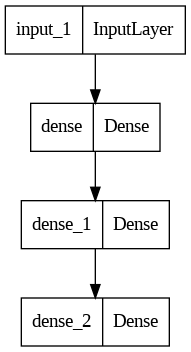

In [9]:
keras.utils.plot_model(model, "my_first_model.png")

And, optionally, display the input and output shapes of each layer
in the plotted graph:

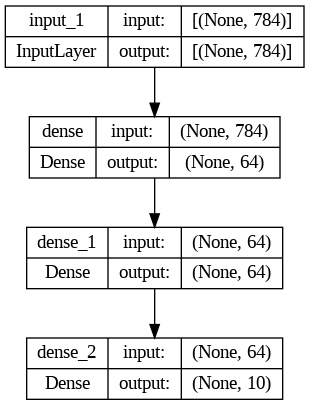

In [10]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

This figure and the code are almost identical. In the code version,
the connection arrows are replaced by the call operation.

A "graph of layers" is an intuitive mental image for a deep learning model,
and the functional API is a way to create models that closely mirrors this.

## Training, evaluation, and inference

Training, evaluation, and inference work exactly in the same way for models
built using the functional API as for `Sequential` models.

Here, load the MNIST image data, reshape it into vectors,
fit the model on the data (while monitoring performance on a validation split),
then evaluate the model on the test data:

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.3512 - accuracy: 0.9009 - val_loss: 0.1881 - val_accuracy: 0.9453
Epoch 2/2
750/750 [==============================] - 3s 4ms/step - loss: 0.1702 - accuracy: 0.9495 - val_loss: 0.1440 - val_accuracy: 0.9558
313/313 - 0s - loss: 0.1505 - accuracy: 0.9550 - 448ms/epoch - 1ms/step
Test loss: 0.1504540741443634
Test accuracy: 0.9549999833106995


For further reading, see the [training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate/) guide.

## Save and serialize

Saving the model and serialization work the same way for models built using
the functional API as they do for `Sequential` models. The standard way
to save a functional model is to call `model.save()`
to save the entire model as a single file. You can later recreate the same model
from this file, even if the code that built the model is no longer available.

This saved file includes the:
- model architecture
- model weight values (that were learned during training)
- model training config, if any (as passed to `compile`)
- optimizer and its state, if any (to restart training where you left off)

In [ ]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

For details, read the model [serialization & saving](
https://www.tensorflow.org/guide/keras/save_and_serialize/) guide.

## Use the same graph of layers to define multiple models

In the functional API, models are created by specifying their inputs
and outputs in a graph of layers. That means that a single
graph of layers can be used to generate multiple models.

In the example below, you use the same stack of layers to instantiate two models:
an `encoder` model that turns image inputs into 16-dimensional vectors,
and an end-to-end `autoencoder` model for training.

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           

Here, the decoding architecture is strictly symmetrical
to the encoding architecture, so the output shape is the same as
the input shape `(28, 28, 1)`.

The reverse of a `Conv2D` layer is a `Conv2DTranspose` layer,
and the reverse of a `MaxPooling2D` layer is an `UpSampling2D` layer.

## All models are callable, just like layers

You can treat any model as if it were a layer by invoking it on an `Input` or
on the output of another layer. By calling a model you aren't just reusing
the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that
creates an encoder model, a decoder model, and chains them in two calls
to obtain the autoencoder model:

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

As you can see, the model can be nested: a model can contain sub-models
(since a model is just like a layer).
A common use case for model nesting is *ensembling*.
For example, here's how to ensemble a set of models into a single model
that averages their predictions:

In [ ]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

## Manipulate complex graph topologies

### Models with multiple inputs and outputs

The functional API makes it easy to manipulate multiple inputs and outputs.
This cannot be handled with the `Sequential` API.

For example, if you're building a system for ranking customer issue tickets by
priority and routing them to the correct department,
then the model will have three inputs:

- the title of the ticket (text input),
- the text body of the ticket (text input), and
- any tags added by the user (categorical input)

This model will have two outputs:

- the priority score between 0 and 1 (scalar sigmoid output), and
- the department that should handle the ticket (softmax output
over the set of departments).

You can build this model in a few lines with the functional API:

In [12]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

Now plot the model:

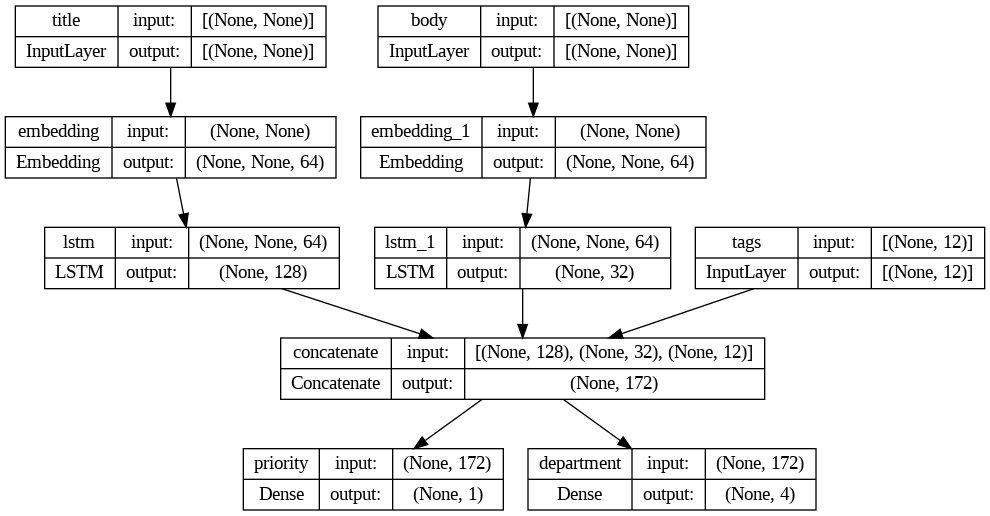

In [13]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output.
You can even assign different weights to each loss -- to modulate
their contribution to the total training loss.

In [14]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

Since the output layers have different names, you could also specify
the loss like this:

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

Train the model by passing lists of NumPy arrays of inputs and targets:

In [ ]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 [==============================] - 2s 40ms/step - loss: 1.2888 - priority_loss: 0.7126 - department_loss: 2.8808
Epoch 2/2
40/40 [==============================] - 2s 41ms/step - loss: 1.2711 - priority_loss: 0.6978 - department_loss: 2.8665


When calling fit with a `Dataset` object, it should yield either a
tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])`
or a tuple of dictionaries like
`({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.

For more detailed explanation, refer to the [training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate/) guide.

### A toy ResNet model

In addition to models with multiple inputs and outputs,
the functional API makes it easy to manipulate non-linear connectivity
topologies -- these are models with layers that are not connected sequentially,
which the `Sequential` API cannot handle.

A common use case for this is residual connections.
Let's build a toy ResNet model for CIFAR10 to demonstrate this:

In [ ]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_5[0][0]']               
                                                                                         

Plot the model:

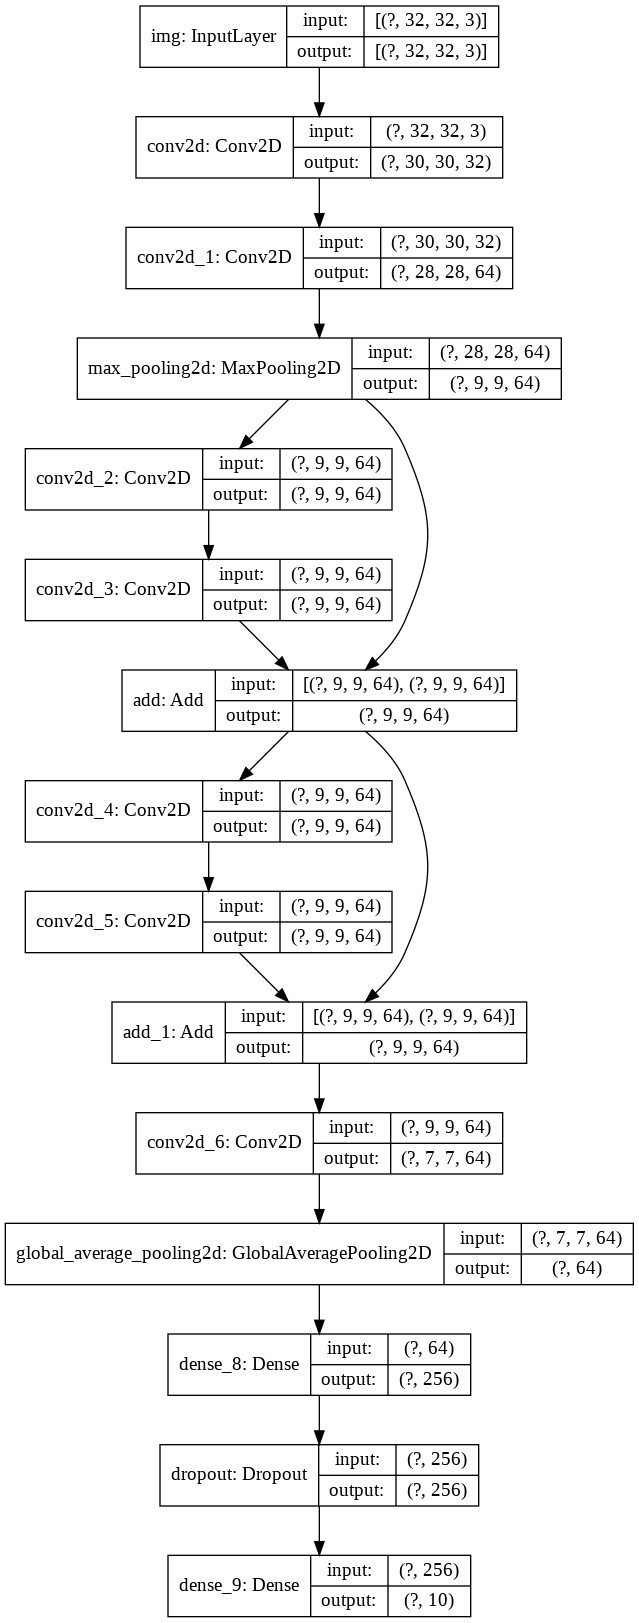

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

Now train the model:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

## Shared layers

Another good use for the functional API are models that use *shared layers*.
Shared layers are layer instances that are reused multiple times in the same model --
they learn features that correspond to multiple paths in the graph-of-layers.

Shared layers are often used to encode inputs from similar spaces
(say, two different pieces of text that feature similar vocabulary).
They enable sharing of information across these different inputs,
and they make it possible to train such a model on less data.
If a given word is seen in one of the inputs,
that will benefit the processing of all inputs that pass through the shared layer.

To share a layer in the functional API, call the same layer instance multiple times.
For instance, here's an `Embedding` layer shared across two different text inputs:

In [ ]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)